In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ecg-image-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F875281%2F1490938%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T133736Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97505eae9a7c86113a30cec58d5fe1642cce0f2247a9373077f5645029c1845ced216bc87b9448f4567ee939cc35cb3319a7536ed6b7bf3dcd6a3a079ff8e104c5e462b53c53413e87cb25dee0b3fa63605bb3514455094316c38562687a470f56b2f2d9e1f8c6cc99da75413f157fe1722ebc2a68059a56e4a8e9b2a3b94cce3f68109650112b19698a052814862d1a7cab247d286513e830c0a14f3e369b7542bbe95953414daf55b8dc5810a347f304c70d1ae03e2be53b5549044e94cc27fed5e017f510f86cd00412b96b419860654b6e4f902be2e62138e8dbd87ff6654d1df7d84aa75fa706adf406028945b033045404572472fa59ec24e7f1f7d949'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 899782756 bytes downloaded
Downloaded and uncompressed: ecg-image-data
Data source import complete.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define constants
IMAGE_SIZE = [224, 224]  # ResNet50 model requires input size (224, 224)
BATCH_SIZE = 32
train_path = '../input/ecg-image-data/ECG_Image_data/train'
valid_path = '../input/ecg-image-data/ECG_Image_data/test'


In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical')


Found 99199 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


In [4]:
# Load pre-trained ResNet50 model
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(training_set.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [5]:
# Train the model
history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=4,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(test_set))


Epoch 1/4
3100/3100 [==============================] - 1546s 496ms/step - loss: 0.1366 - accuracy: 0.9549 - val_loss: 0.0874 - val_accuracy: 0.9707
Epoch 2/4
3100/3100 [==============================] - 1492s 481ms/step - loss: 0.0610 - accuracy: 0.9783 - val_loss: 0.0552 - val_accuracy: 0.9813
Epoch 3/4
3100/3100 [==============================] - 1483s 478ms/step - loss: 0.0496 - accuracy: 0.9828 - val_loss: 0.1193 - val_accuracy: 0.9599
Epoch 4/4
3100/3100 [==============================] - 1501s 484ms/step - loss: 0.0416 - accuracy: 0.9856 - val_loss: 0.0791 - val_accuracy: 0.9720


In [6]:
# Evaluate model on the entire test set
test_loss, test_accuracy = model.evaluate(test_set, steps=len(test_set))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


775/775 [==============================] - 103s 133ms/step - loss: 0.0791 - accuracy: 0.9720
Test Loss: 0.07913734018802643
Test Accuracy: 0.9720150232315063


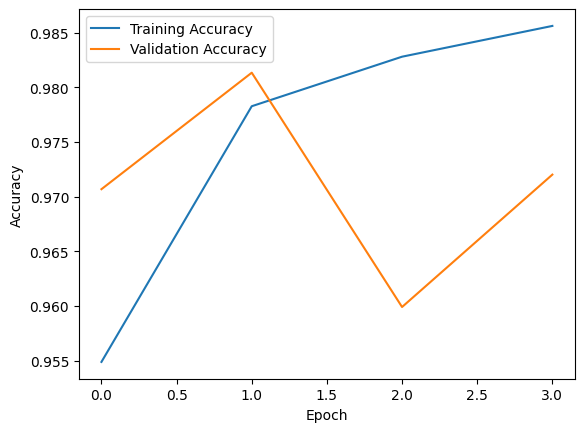

In [7]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


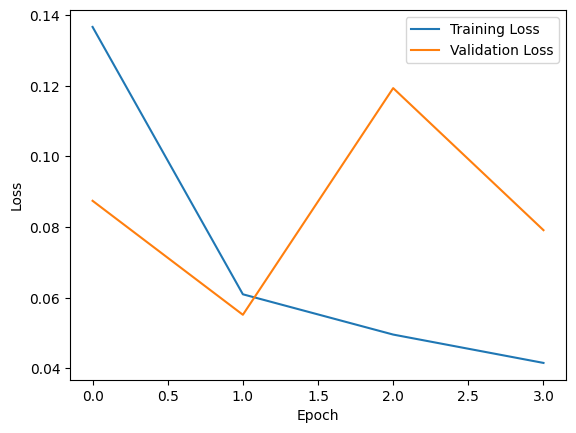

In [8]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Rescale pixel values to [0, 1]
    return img_array

def classify_image(model, image_path, class_indices):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = class_indices[np.argmax(prediction)]
    return predicted_class

class_indices = {0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}  # Update with your class indices

image_path = '../input/ecg-image-data/ECG_Image_data/test/S/S956.png'  # Update with the path to your PNG image
predicted_class = classify_image(model, image_path, class_indices)
print("Predicted Class:", predicted_class)


1/1 [==============================] - 2s 2s/step
Predicted Class: S
